**Materia Implementación de Aplicaciones de Aprendizaje Automático en la Nube**

**TRABAJO PRACTICO**



**Introduccion**

Un gerente comercial de un banco de tarjetas de crédito está atravesando un problema de perdida clientes. Quieren analizar los datos para descubrir cual es la causa y aprovechar para predecir los clientes que probablemente se den de baja, para lanzar una campaña de retención focalizada en dicho universo.

Fuente de datos https://www.kaggle.com/code/ganlak/credit-card-prediction-for-attrition-customer/data

**Columnas que componen el dataset:**

* CLIENTNUM
* Attrition_Flag
* Customer_Age
* Gender
* Dependent_count
* Education_Level
* Marital_Status
* Income_Category
* Card_Category
* Months_on_book
* Total_Relationship_Count
* Months_Inactive_12_mon
* Contacts_Count_12_mon
* Credit_Limit
* Total_Revolving_Bal
* Avg_Open_To_Buy
* Total_Amt_Chng_Q4_Q1
* Total_Trans_Amt
* Total_Trans_Ct
* Total_Ct_Chng_Q4_Q1
* Avg_Utilization_Ratio



In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#import plotly.express as px
%matplotlib inline


# Utilities
import os
import pickle
import requests as req
from io import BytesIO
import boto3


# MachineLearning
from catboost import CatBoostClassifier


import scipy.stats as st

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from keras.utils import to_categorical

# Main modules
import predictions as pr


In [2]:
#!pip install catboost

In [3]:
REGION = 'us-east-1'
BUCKET_NAME = 'mma-models-in-production' # Unique through all accounts
FOLDER = 'dist' # Should be clean before the execution



---
#### **Importación del Dataset**


---





In [4]:
path = 'https://raw.githubusercontent.com/guilledesimone/MMA-AppNube/main/data/credit_card_churn.csv'

# Read the CSV file with coma as delimiter, 
df = pd.read_csv(path, delimiter=',', header=0)

df.head(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


---
## **Analisis Exploratorio del Dataset**

---

In [5]:
#df.info()

In [6]:
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.159997,0.840003
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.365301,0.365301
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000008,0.000420
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000099,0.999660
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000181,0.999820
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000337,0.999900
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,0.999580,0.999990


*Eliminamos columnas que claramente no son relevantes para el análisis (CLIENTNUM, Naive_Bayes_Classifier)*

In [7]:
df.drop(df.loc[:,['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']], axis=1, inplace=True)

In [8]:
df.shape

(10127, 20)

*Análisis de duplicados*

In [9]:
df.duplicated().sum()

0

*Verificamos nulos*

In [10]:
df.isnull().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

*Analisis de Outliers:*

In [11]:
dfnum=df.select_dtypes(include=['int64','float64'])

In [12]:
for i, col in enumerate(dfnum.columns):
  print(col,'Max:',dfnum[col].max(),' ',col,'Percentil 99:',dfnum[col].quantile(0.99))

Customer_Age Max: 73   Customer_Age Percentil 99: 65.0
Dependent_count Max: 5   Dependent_count Percentil 99: 5.0
Months_on_book Max: 56   Months_on_book Percentil 99: 56.0
Total_Relationship_Count Max: 6   Total_Relationship_Count Percentil 99: 6.0
Months_Inactive_12_mon Max: 6   Months_Inactive_12_mon Percentil 99: 6.0
Contacts_Count_12_mon Max: 6   Contacts_Count_12_mon Percentil 99: 5.0
Credit_Limit Max: 34516.0   Credit_Limit Percentil 99: 34516.0
Total_Revolving_Bal Max: 2517   Total_Revolving_Bal Percentil 99: 2517.0
Avg_Open_To_Buy Max: 34516.0   Avg_Open_To_Buy Percentil 99: 34294.14
Total_Amt_Chng_Q4_Q1 Max: 3.397   Total_Amt_Chng_Q4_Q1 Percentil 99: 1.5147399999999998
Total_Trans_Amt Max: 18484   Total_Trans_Amt Percentil 99: 15882.359999999997
Total_Trans_Ct Max: 139   Total_Trans_Ct Percentil 99: 123.0
Total_Ct_Chng_Q4_Q1 Max: 3.714   Total_Ct_Chng_Q4_Q1 Percentil 99: 1.455
Avg_Utilization_Ratio Max: 0.999   Avg_Utilization_Ratio Percentil 99: 0.9057399999999998


No se ven grandes diferencias entre los valores maximos y el percentil 99 de las variables por lo tanto bajo este criterio los valores extremos no son llamativos. Ampliamos el análisis en los siguientes graficos con Boxplot dividiendo por variable objetivo Atriction Flag.

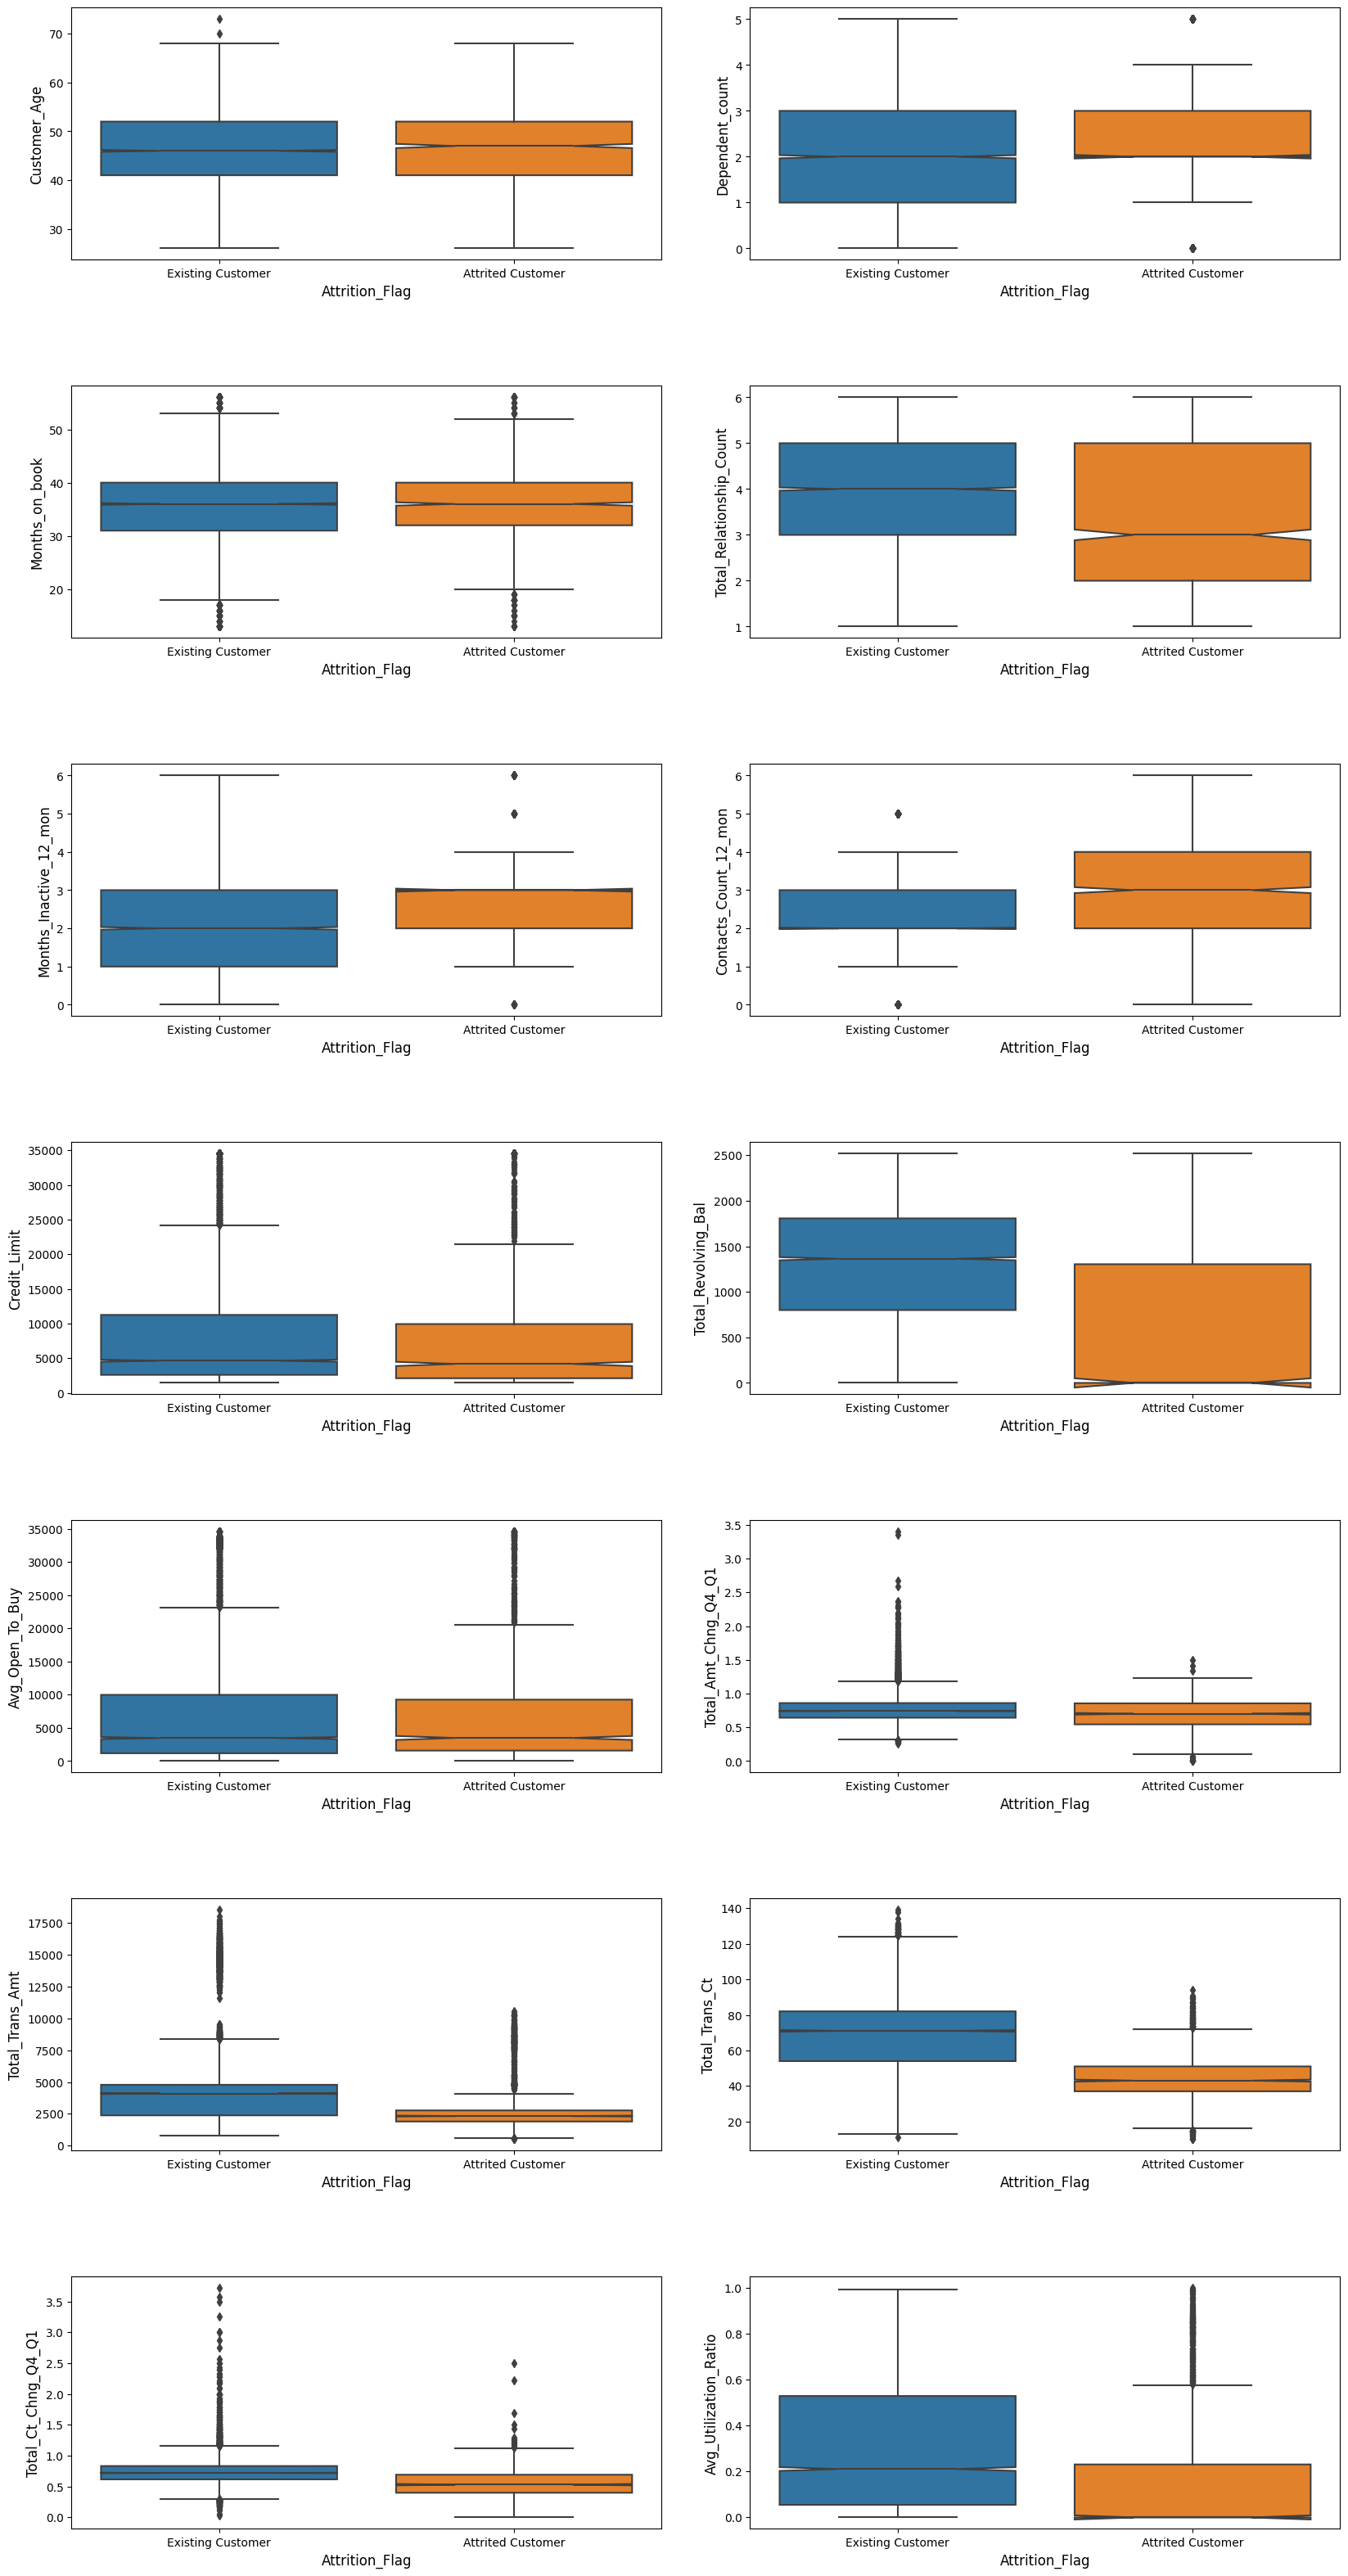

In [13]:
f,ax = plt.subplots(int(len(dfnum.columns)/2),2,figsize=(20,40),gridspec_kw={'wspace':0.15,'hspace':0.50})

ax = ax.ravel()
for i,col in enumerate(dfnum.columns):
  sns.boxplot(x = df.Attrition_Flag, y = dfnum[col], ax=ax[i],notch=True);
  ax[i].xaxis.get_label().set_fontsize(12)
  ax[i].yaxis.get_label().set_fontsize(12)

De las observaciones de los graficos se notan valores extremos en base a la clase de la variable objetivo:
* Month on Book: para ambas clases.
* Months_Inactive_12_mon: La media es considerablemente mayor para Attrited Customers, e incluso muestra algunos pocos valores extremos
* Credit_Limit, Avg_Open_To_Buy: para ambas clases, en el extremo superior.
* Total_Trans_Amt y Ct: presentan valores extremos superiores, sin embargo la media y los valores extremos son considerablemente menores para Attrited Customers
* Avg_Utilization_Ratio: para Attrited Customers se observan valores extremos. Sin embargo la media es menor que la de Existing Customer inluso cerana a 0. Conclusion para esta clase solo un pequeño grupo demuestra una tasa elevada de uso.
* Total_Revolving_Bal: indica el refinanciamiento del saldo de la tarjeta. No presenta valores extremos, sin embargo para Attrited Customers la media es cercana a 0, de hecho la media de Existing Custumers supera al maximo de Attrited Customers. Es decir los Existing Customers se financian en mayor medida con el descubierto de la tarjeta de credtito que los Attrited Customers   

*Analisis de distribución de los datos en las variables numéricas*

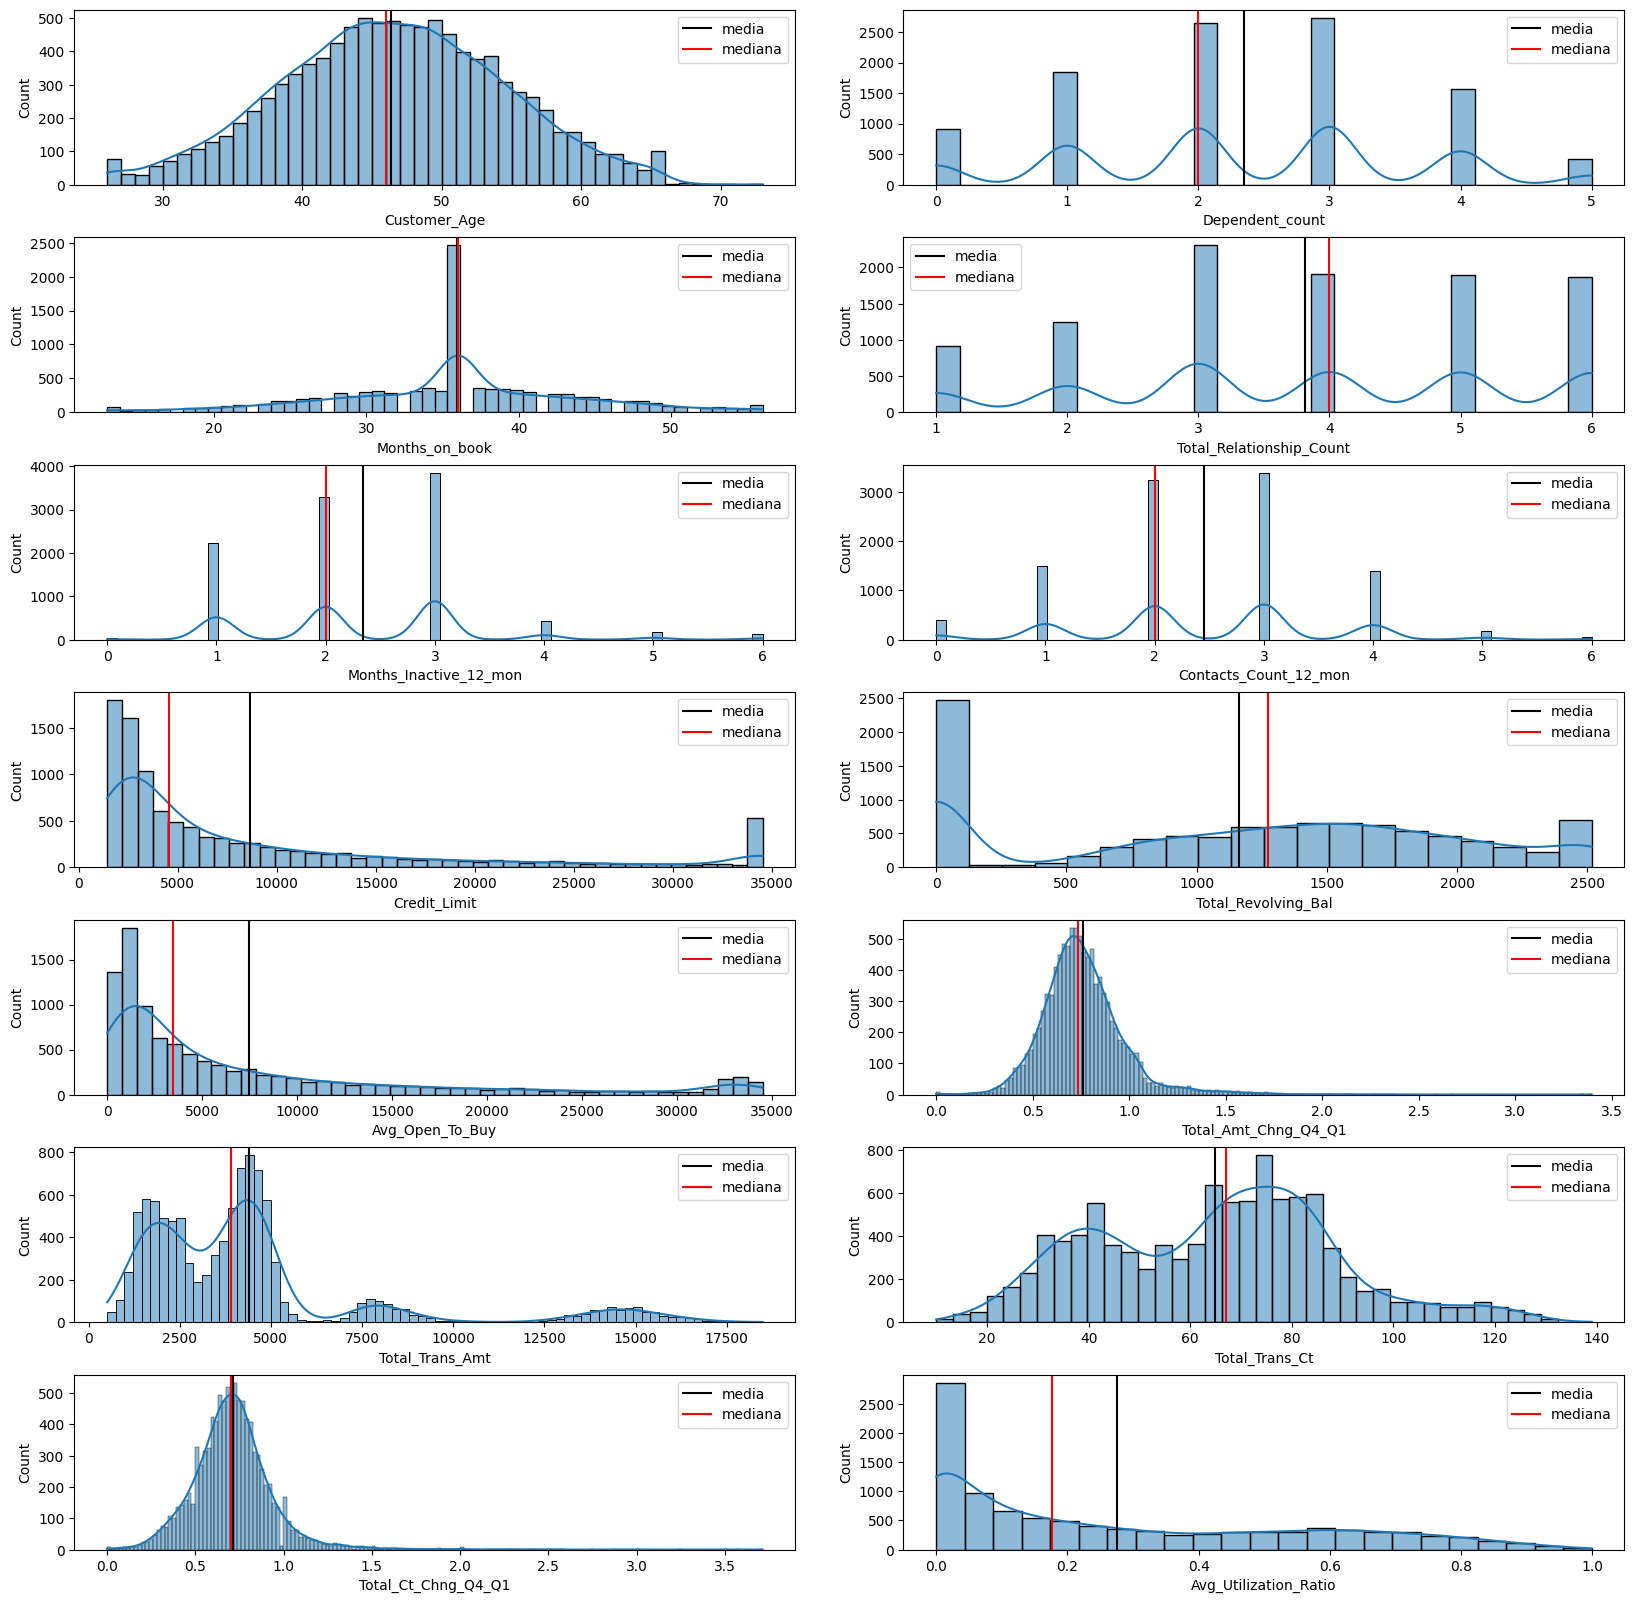

In [14]:
# Distribuciones para cada variable numerica
f,ax = plt.subplots(int(len(dfnum.columns)/2),2,figsize=(20,20),gridspec_kw={'wspace':0.15,'hspace':0.30})

ax = ax.ravel()
for i,col in enumerate(dfnum.columns):
    sns.histplot(df[col].astype(float),ax=ax[i],kde=True)
    ax[i].axvline(x=df[col].mean(),color='k',label='media')
    ax[i].axvline(x=df[col].median(),color='r',label='mediana')
    ax[i].legend()   


Observamos distribuciones normales con colas simetricas solo para Customer_Age, Total_Amt_Chng_Q4_Q1, Total_Ct_Chng_Q4_Q1.

Para los features de Credit_Limit, Avg_open_To_Buy, Total_Trans_Amt, Dependant_Count y Avg_Utilization_Ratio tienen una ditribución más pesada por debajo de la media, en cambio el resto se comporta al revés


*Separamos en columnas categoricas y numéricas*

In [15]:
categorical = list(df.select_dtypes(include=['object']).columns)
numerical = list(df.select_dtypes(include=['int64','float64']).columns)

print(f'Las columnas categóricas son: {categorical} \nLas columnas numéricas son: {numerical}')

Las columnas categóricas son: ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category'] 
Las columnas numéricas son: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


---
#### **Feature Selection**

---

*Analizamos Correlaciones*

<Axes: >

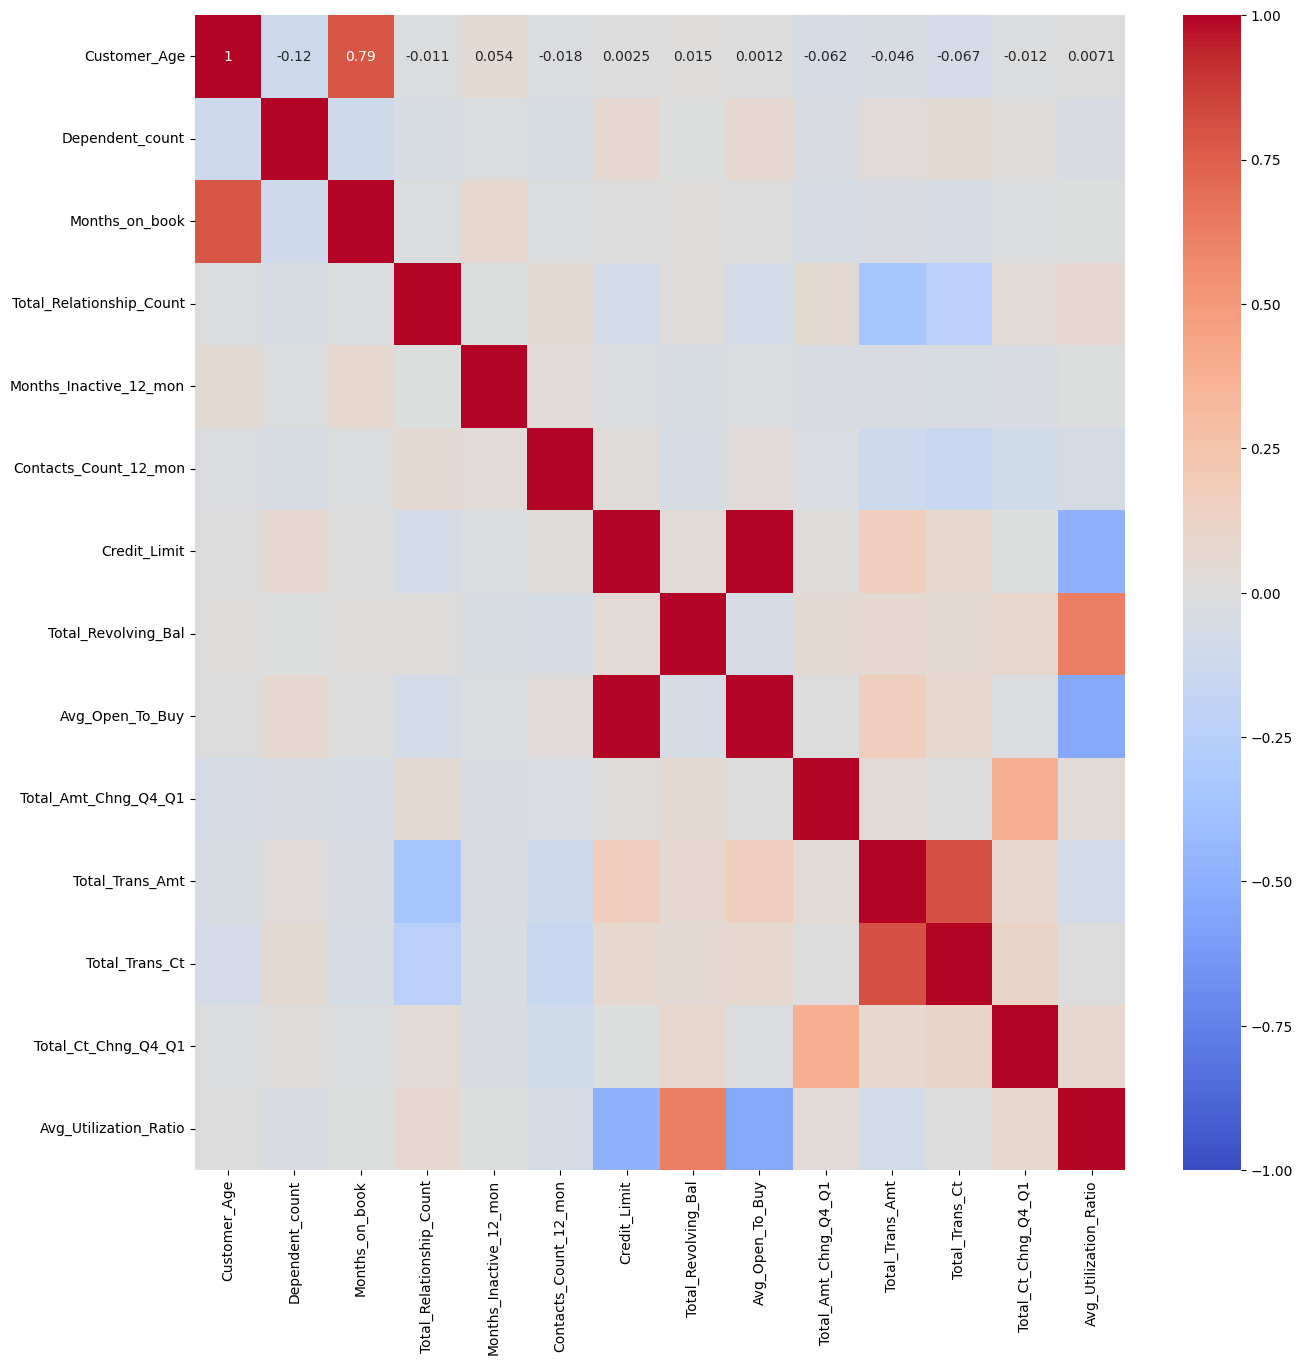

In [16]:
plt.figure(figsize=(15,15))
sns.heatmap(dfnum.corr(),annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')


*Graficamos un Pair Plot*

In [17]:
#graficamos en el pair plot las variables con mayores correlaciones
vars= ['Total_Revolving_Bal','Credit_Limit','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1','Avg_Open_To_Buy','Months_on_book','Customer_Age']

#sns.pairplot(data=df, vars=vars, hue='Attrition_Flag');

Se puede observar que existe una gran correlación entre las variables:

* Credit_Limit
* Avg_Open_To_Buy
* Months_on_book
* Customer_Age



*Descartamos variables con mayores correlaciones:*

In [18]:
#df.drop(df.loc[:,['Credit_Limit','Avg_Open_To_Buy', 'Months_on_book','Customer_Age']], axis=1, inplace=True)


# Cuando probamos de quitar tambien Total_Revolving_Bal','Total_Trans_Ct' los resultados de 
# performance empeoraron por este motivo las mantuvimos
df.drop(df.loc[:,['Credit_Limit','Avg_Open_To_Buy', 'Months_on_book','Customer_Age','Total_Revolving_Bal','Total_Trans_Ct']], axis=1, inplace=True)


In [19]:
df.shape

(10127, 14)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Gender                    10127 non-null  object 
 2   Dependent_count           10127 non-null  int64  
 3   Education_Level           10127 non-null  object 
 4   Marital_Status            10127 non-null  object 
 5   Income_Category           10127 non-null  object 
 6   Card_Category             10127 non-null  object 
 7   Total_Relationship_Count  10127 non-null  int64  
 8   Months_Inactive_12_mon    10127 non-null  int64  
 9   Contacts_Count_12_mon     10127 non-null  int64  
 10  Total_Amt_Chng_Q4_Q1      10127 non-null  float64
 11  Total_Trans_Amt           10127 non-null  int64  
 12  Total_Ct_Chng_Q4_Q1       10127 non-null  float64
 13  Avg_Utilization_Ratio     10127 non-null  float64
dtypes: flo

In [21]:
df.drop(df.loc[:,['Total_Relationship_Count', 'Total_Amt_Chng_Q4_Q1','Total_Relationship_Count']], axis=1, inplace=True)

*Analisis de independencia de variables catagoricas respecto a la variable objetivo:* 

In [22]:
dfcategoricas=df.select_dtypes(include=['object'])

In [23]:
for col in [c for c in dfcategoricas.columns if c not in ['Attrition_Flag']]:
  crosstab=pd.crosstab(dfcategoricas['Attrition_Flag'],dfcategoricas[col],normalize='index',margins = False).round(4)*100
  display(crosstab.T)
  stat,p_value,dof,expected=st.chi2_contingency(crosstab);
  print('Confianza para rechazar HO de variables Independientes: {}%'.format(((1-p_value)*100).round(2)))


Attrition_Flag,Attrited Customer,Existing Customer
Gender,,
F,57.16,52.09
M,42.84,47.91


Confianza para rechazar HO de variables Independientes: 43.68%


Attrition_Flag,Attrited Customer,Existing Customer
Education_Level,,
College,9.47,10.11
Doctorate,5.84,4.19
Graduate,29.93,31.07
High School,18.81,20.08
Post-Graduate,5.65,4.99
Uneducated,14.57,14.71
Unknown,15.73,14.86


Confianza para rechazar HO de variables Independientes: 0.13%


Attrition_Flag,Attrited Customer,Existing Customer
Marital_Status,,
Divorced,7.44,7.38
Married,43.58,46.80
Single,41.06,38.53
Unknown,7.93,7.29


Confianza para rechazar HO de variables Independientes: 2.61%


Attrition_Flag,Attrited Customer,Existing Customer
Income_Category,,
$120K +,7.74,7.07
$40K - $60K,16.66,17.87
$60K - $80K,11.62,14.27
$80K - $120K,14.87,15.21
Less than $40K,37.62,34.69
Unknown,11.49,10.88


Confianza para rechazar HO de variables Independientes: 0.73%


Attrition_Flag,Attrited Customer,Existing Customer
Card_Category,,
Blue,93.36,93.14
Gold,1.29,1.12
Platinum,0.31,0.18
Silver,5.04,5.56


Confianza para rechazar HO de variables Independientes: 0.51%


*Conclusion:* No podemos rechazar H0 de que son indenpendientes, pero si las quitamos el accuaracy cae solo 4 puntos y el modelo se llama con muchas menos variables.

In [24]:
df.drop(df.loc[:,['Gender', 'Education_Level','Marital_Status','Income_Category','Card_Category']], axis=1, inplace=True)

In [25]:
df.shape

(10127, 7)

#*Generamos las variables dummy:*

In [26]:
data = pd.get_dummies(df, drop_first=True)
data.head()

,Dependent_count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Trans_Amt,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag_Existing Customer
0,3,1,3,1144,1.625,0.061,True
1,5,1,2,1291,3.714,0.105,True
2,3,1,0,1887,2.333,0.000,True
3,4,4,1,1171,2.333,0.760,True
4,3,1,0,816,2.500,0.000,True


In [27]:
#Invertimos los Flags 0 por 1 para Attrition_Flag_Existing Customer para cambiarlo a  Attrition_Flag_Attrited_Customer

data.loc[data['Attrition_Flag_Existing Customer']==1,'Attrition_Flag_Existing Customer']=2
data.loc[data['Attrition_Flag_Existing Customer']==0,'Attrition_Flag_Existing Customer']=1
data.loc[data['Attrition_Flag_Existing Customer']==2,'Attrition_Flag_Existing Customer']=0

In [28]:
data.rename(columns={'Attrition_Flag_Existing Customer':'Attrition_Flag_Attrited_Customer'},inplace=True)

In [29]:
#### Encoder de los datos target

In [30]:
#def fit_encoder(target_list: list) -> LabelEncoder:
#    """
#        Fit a scikit-learn LabelEncoder based on target_list.
#    """    
#    encoder = LabelEncoder()
#    print('Fitting a LabelEncoder with given target')
#    encoder.fit(target_list)
    
#    print('Found classes', encoder.classes_)
#    print('Testing encoder', encoder.transform(encoder.classes_))
#    
#    file_name = 'encoder.pkl'
#    with open(os.path.join(FOLDER, file_name), 'wb') as f:
#        pickle.dump(encoder, f)

    # TODO Part 2        
    # au.upload_to_s3(BUCKET_NAME, FOLDER, file_name)        
    
#    print('Encoder saved')
#    return encoder

In [31]:
# All the target column
#target_list = df['Attrition_Flag'].tolist()
#encoder = fit_encoder(target_list)

In [32]:
#def encode_and_one_hot_target(target_list: list, encoder: LabelEncoder) -> np.ndarray:
#    print('Encoding target with given encoder')
#    targets_encoded = encoder.transform(target_list)

#    print('Convert encoded classes integers to dummy variables')
#    targets_one_hot = to_categorical(targets_encoded)
    
#    print('Target final shape', targets_one_hot.shape)
#    return targets_one_hot

In [33]:
#y = encode_and_one_hot_target(target_list, encoder)

## **Modelos de Machine Learning**


In [34]:
##
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Dependent_count                   10127 non-null  int64  
 1   Months_Inactive_12_mon            10127 non-null  int64  
 2   Contacts_Count_12_mon             10127 non-null  int64  
 3   Total_Trans_Amt                   10127 non-null  int64  
 4   Total_Ct_Chng_Q4_Q1               10127 non-null  float64
 5   Avg_Utilization_Ratio             10127 non-null  float64
 6   Attrition_Flag_Attrited_Customer  10127 non-null  object 
dtypes: float64(2), int64(4), object(1)
memory usage: 553.9+ KB


In [35]:
#X = df.drop(["Attrition_Flag"], axis = 1)



y = data['Attrition_Flag_Attrited_Customer']
X = data.drop(['Attrition_Flag_Attrited_Customer'], axis = 1)

In [36]:
#df['Attrition_Flag'].value_counts(normalize=True)
data['Attrition_Flag_Attrited_Customer'].value_counts(normalize=True)

Attrition_Flag_Attrited_Customer
0    0.83934
1    0.16066
Name: proportion, dtype: float64

*Division del Dataset en Train y Test:*

Como las clases están muy desbalanceadas lo tenemos en cuenta en el split, con el stratify. Tambien al evaluar el modelo utilizando F1score en lugar de accuracy

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=14)

**Normalización de los datos**

In [38]:
def fit_normalizer(input_data: pd.DataFrame) -> StandardScaler:
    """
        Fit a scikit-learn Normalizer based on input_data.
    """    
    scaler = StandardScaler()
    print('Fitting a Normalizer with given input')    
    scaler.fit(input_data)
    
    file_name = 'normalizer.pkl'
    with open(os.path.join(FOLDER, file_name), 'wb') as f:
        pickle.dump(scaler, f)
    
    # TODO Part 2
    # au.upload_to_s3(BUCKET_NAME, FOLDER, file_name)        
    
    print('Normalizer saved')
    return scaler

In [39]:
#El normalizer se debe fitear con el set de entrenamiento unicamente

stds = fit_normalizer(X_train)

Fitting a Normalizer with given input
Normalizer saved


In [40]:
X_train = pd.DataFrame(stds.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(stds.transform(X_test), columns=X.columns)


In [41]:
X_train.shape

(7595, 6)

In [42]:
X_test.shape

(2532, 6)

In [43]:
y_train.shape

(7595,)

In [44]:
y_test.shape

(2532,)

In [45]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7595 entries, 0 to 7594
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Dependent_count         7595 non-null   float64
 1   Months_Inactive_12_mon  7595 non-null   float64
 2   Contacts_Count_12_mon   7595 non-null   float64
 3   Total_Trans_Amt         7595 non-null   float64
 4   Total_Ct_Chng_Q4_Q1     7595 non-null   float64
 5   Avg_Utilization_Ratio   7595 non-null   float64
dtypes: float64(6)
memory usage: 356.1 KB


**CatBoost**

In [46]:
def fit_CatBoost(X_train: np.ndarray, y_train: np.ndarray) -> CatBoostClassifier:
    """
        Fits a CatBoost model, saves the model weights and returns it.
    """
    # Instantiate the model learning model 
    model_cat = CatBoostClassifier()
    
    # Fitting the model
    print('Fitting model')
    model=model_cat.fit(X_train, y_train)
    
    file_name = 'model.pkl'
    with open(os.path.join(FOLDER, file_name), 'wb') as f:
        pickle.dump(model, f)
      
    # TODO Part 2    
    # au.upload_to_s3(BUCKET_NAME, FOLDER, file_name)        

    print('Model saved')
    return model

In [47]:
model_cat = fit_CatBoost(X_train, y_train)


Fitting model
Learning rate set to 0.024486
0:	learn: 0.6603911	total: 148ms	remaining: 2m 28s
1:	learn: 0.6348358	total: 159ms	remaining: 1m 19s
2:	learn: 0.6085342	total: 169ms	remaining: 56s
3:	learn: 0.5906976	total: 180ms	remaining: 44.7s
4:	learn: 0.5708692	total: 192ms	remaining: 38.3s
5:	learn: 0.5516037	total: 199ms	remaining: 33s
6:	learn: 0.5342224	total: 216ms	remaining: 30.7s
7:	learn: 0.5175904	total: 227ms	remaining: 28.2s
8:	learn: 0.5012748	total: 239ms	remaining: 26.3s
9:	learn: 0.4861909	total: 248ms	remaining: 24.6s
10:	learn: 0.4725207	total: 260ms	remaining: 23.4s
11:	learn: 0.4633921	total: 271ms	remaining: 22.3s
12:	learn: 0.4507605	total: 279ms	remaining: 21.2s
13:	learn: 0.4350548	total: 292ms	remaining: 20.6s
14:	learn: 0.4238282	total: 304ms	remaining: 19.9s
15:	learn: 0.4138263	total: 314ms	remaining: 19.3s
16:	learn: 0.4025661	total: 327ms	remaining: 18.9s
17:	learn: 0.3951659	total: 340ms	remaining: 18.6s
18:	learn: 0.3874344	total: 355ms	remaining: 18.3s

165:	learn: 0.1874887	total: 1.84s	remaining: 9.24s
166:	learn: 0.1871765	total: 1.85s	remaining: 9.22s
167:	learn: 0.1868194	total: 1.86s	remaining: 9.21s
168:	learn: 0.1866137	total: 1.87s	remaining: 9.18s
169:	learn: 0.1863963	total: 1.88s	remaining: 9.16s
170:	learn: 0.1859865	total: 1.89s	remaining: 9.14s
171:	learn: 0.1857501	total: 1.89s	remaining: 9.12s
172:	learn: 0.1855095	total: 1.9s	remaining: 9.09s
173:	learn: 0.1853515	total: 1.91s	remaining: 9.07s
174:	learn: 0.1851333	total: 1.92s	remaining: 9.04s
175:	learn: 0.1849094	total: 1.93s	remaining: 9.03s
176:	learn: 0.1846470	total: 1.94s	remaining: 9.01s
177:	learn: 0.1844216	total: 1.95s	remaining: 9.01s
178:	learn: 0.1842039	total: 1.96s	remaining: 9.01s
179:	learn: 0.1840055	total: 1.97s	remaining: 8.98s
180:	learn: 0.1837832	total: 1.98s	remaining: 8.97s
181:	learn: 0.1836052	total: 1.99s	remaining: 8.96s
182:	learn: 0.1834533	total: 2s	remaining: 8.95s
183:	learn: 0.1832633	total: 2.02s	remaining: 8.94s
184:	learn: 0.18

324:	learn: 0.1633258	total: 3.73s	remaining: 7.75s
325:	learn: 0.1632477	total: 3.74s	remaining: 7.74s
326:	learn: 0.1630614	total: 3.75s	remaining: 7.72s
327:	learn: 0.1629374	total: 3.76s	remaining: 7.71s
328:	learn: 0.1628573	total: 3.77s	remaining: 7.69s
329:	learn: 0.1627395	total: 3.78s	remaining: 7.67s
330:	learn: 0.1626379	total: 3.79s	remaining: 7.65s
331:	learn: 0.1624974	total: 3.79s	remaining: 7.63s
332:	learn: 0.1624208	total: 3.8s	remaining: 7.62s
333:	learn: 0.1623406	total: 3.81s	remaining: 7.6s
334:	learn: 0.1622963	total: 3.82s	remaining: 7.58s
335:	learn: 0.1621713	total: 3.82s	remaining: 7.56s
336:	learn: 0.1620479	total: 3.83s	remaining: 7.54s
337:	learn: 0.1618644	total: 3.84s	remaining: 7.52s
338:	learn: 0.1618188	total: 3.85s	remaining: 7.5s
339:	learn: 0.1616998	total: 3.85s	remaining: 7.48s
340:	learn: 0.1616044	total: 3.86s	remaining: 7.46s
341:	learn: 0.1615355	total: 3.87s	remaining: 7.44s
342:	learn: 0.1614255	total: 3.87s	remaining: 7.42s
343:	learn: 0.1

493:	learn: 0.1473332	total: 5.16s	remaining: 5.28s
494:	learn: 0.1472741	total: 5.16s	remaining: 5.27s
495:	learn: 0.1471811	total: 5.17s	remaining: 5.26s
496:	learn: 0.1471145	total: 5.18s	remaining: 5.24s
497:	learn: 0.1470129	total: 5.19s	remaining: 5.23s
498:	learn: 0.1469252	total: 5.2s	remaining: 5.22s
499:	learn: 0.1468315	total: 5.2s	remaining: 5.2s
500:	learn: 0.1467262	total: 5.21s	remaining: 5.19s
501:	learn: 0.1466474	total: 5.21s	remaining: 5.17s
502:	learn: 0.1465711	total: 5.22s	remaining: 5.16s
503:	learn: 0.1464939	total: 5.23s	remaining: 5.15s
504:	learn: 0.1464105	total: 5.24s	remaining: 5.14s
505:	learn: 0.1462956	total: 5.25s	remaining: 5.12s
506:	learn: 0.1462273	total: 5.25s	remaining: 5.11s
507:	learn: 0.1461282	total: 5.26s	remaining: 5.1s
508:	learn: 0.1460360	total: 5.27s	remaining: 5.09s
509:	learn: 0.1459666	total: 5.28s	remaining: 5.07s
510:	learn: 0.1458910	total: 5.29s	remaining: 5.06s
511:	learn: 0.1458314	total: 5.3s	remaining: 5.05s
512:	learn: 0.145

671:	learn: 0.1345110	total: 6.79s	remaining: 3.31s
672:	learn: 0.1344690	total: 6.8s	remaining: 3.3s
673:	learn: 0.1344008	total: 6.81s	remaining: 3.3s
674:	learn: 0.1343312	total: 6.83s	remaining: 3.29s
675:	learn: 0.1342812	total: 6.84s	remaining: 3.28s
676:	learn: 0.1342315	total: 6.85s	remaining: 3.27s
677:	learn: 0.1342041	total: 6.85s	remaining: 3.25s
678:	learn: 0.1341239	total: 6.86s	remaining: 3.24s
679:	learn: 0.1340897	total: 6.87s	remaining: 3.23s
680:	learn: 0.1340120	total: 6.88s	remaining: 3.22s
681:	learn: 0.1339476	total: 6.89s	remaining: 3.21s
682:	learn: 0.1339092	total: 6.9s	remaining: 3.2s
683:	learn: 0.1338551	total: 6.9s	remaining: 3.19s
684:	learn: 0.1338144	total: 6.91s	remaining: 3.18s
685:	learn: 0.1337543	total: 6.92s	remaining: 3.17s
686:	learn: 0.1336998	total: 6.93s	remaining: 3.16s
687:	learn: 0.1336358	total: 6.93s	remaining: 3.14s
688:	learn: 0.1335894	total: 6.94s	remaining: 3.13s
689:	learn: 0.1335064	total: 6.95s	remaining: 3.12s
690:	learn: 0.1334

844:	learn: 0.1248428	total: 8.03s	remaining: 1.47s
845:	learn: 0.1247584	total: 8.04s	remaining: 1.46s
846:	learn: 0.1247075	total: 8.04s	remaining: 1.45s
847:	learn: 0.1246813	total: 8.05s	remaining: 1.44s
848:	learn: 0.1246112	total: 8.06s	remaining: 1.43s
849:	learn: 0.1245685	total: 8.07s	remaining: 1.42s
850:	learn: 0.1245012	total: 8.08s	remaining: 1.41s
851:	learn: 0.1244209	total: 8.09s	remaining: 1.41s
852:	learn: 0.1243719	total: 8.1s	remaining: 1.4s
853:	learn: 0.1243492	total: 8.11s	remaining: 1.39s
854:	learn: 0.1243089	total: 8.11s	remaining: 1.38s
855:	learn: 0.1242527	total: 8.12s	remaining: 1.37s
856:	learn: 0.1241810	total: 8.13s	remaining: 1.36s
857:	learn: 0.1241176	total: 8.14s	remaining: 1.35s
858:	learn: 0.1240566	total: 8.14s	remaining: 1.34s
859:	learn: 0.1240074	total: 8.15s	remaining: 1.33s
860:	learn: 0.1239493	total: 8.16s	remaining: 1.32s
861:	learn: 0.1238969	total: 8.16s	remaining: 1.31s
862:	learn: 0.1238348	total: 8.17s	remaining: 1.3s
863:	learn: 0.1

In [48]:
predictions = model_cat.predict(X_test)

In [49]:
accuracy = (predictions == y_test).mean()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.92


-------------------------------------------------------------------------------------------------------------------------------


## Código para el servidor

In [ ]:
import predictions as pr
# From package
Existing_Customer = [3, 1, 3, 1144,1.625,0.061]
Attrited_Customer = [0, 3, 3, 692,0.6,0]
pr.predict(Attrited_Customer)

In [ ]:
pr.predict(Existing_Customer)

In [ ]:
!python app.py

In [50]:
# Browser with Public DNS.
# Existing_Customer
req.get('http://localhost:5000/classify?Dependent_count=3&Months_Inactive_12_mon=1&Contacts_Count_12_mon=3&Total_Trans_Amt=1144&Total_Ct_Chng_Q4_Q1=1.625&Avg_Utilization_Ratio=0.061').json()

{'Attrition_Flag': 'Existing_Customer',
 'sample': ['3', '1', '3', '1144', '1.625', '0.061']}

In [51]:
# Browser with Public DNS.
# Attrited_Customer
req.get('http://localhost:5000/classify?Dependent_count=0&Months_Inactive_12_mon=3&Contacts_Count_12_mon=3&Total_Trans_Amt=692&Total_Ct_Chng_Q4_Q1=0.65&Avg_Utilization_Ratio=0').json()

{'Attrition_Flag': 'Attrited_Customer',
 'sample': ['0', '3', '3', '692', '0.65', '0']}

## Packaging & Deploy

In [ ]:
# 1.Create virtual environment with new python executable
virtualenv env --python=python3.10

In [ ]:
# 2.Activate it, prompt changes
#source env/bin/activate #esto es en linux
# In Windows, primero cambiar al path de la carpeta env 
cd env\scripts

In [ ]:
# 3.activate
activate #windows cuando se activa el promt muestra (env) (python-3.11)

In [ ]:
# 4.Install all dependencies in requirements.txt
cd..
cd..
pip install -r requirements.txt

In [ ]:
# 5. Test the app inside virtual environment, stop the above execution in terminal, show the log
python app.py

In [ ]:
#6. ip the app
#In Windows
"C:\Program Files\7-Zip\7z.exe" a -tzip model-POC-in-production.zip app.py predictions.py aws_utils.py config.py requirements.txt dist

## Instancia de AWS - Deploy en EC2

In [ ]:
#En windows con putty, convertir certificado privado .pem a ppk
#login as: ubuntu

###### Cloud: Install python 3.10, pip. virtualenv and unzip

In [ ]:
sudo add-apt-repository ppa:deadsnakes/ppa && sudo apt-get update && sudo apt-get install -y unzip python3.10 python3-pip virtualenv

In [ ]:
# A little shorcut
alias python=python3

##### Local en windows con cmd o Powershell usando Putty # Dir donde esta Putty 

In [ ]:
cd "C:\Program Files\PuTTY"

#Con PowerShell
./pscp -i C:\Users\desim\Documents\MMA\Imp-App-Nube\SSH\labsuser.ppk "C:\Users\desim\Documents\MMA\Imp-App-Nube\Trabajo Final\model-POC-in-production.zip" ubuntu@ec2-34-226-207-234.compute-1.amazonaws.com:/home/ubuntu

###### Cloud: Unzip

In [ ]:
unzip -o model-POC-in-production.zip

###### Cloud: TEST

In [ ]:
virtualenv env --python=python3.10
source env/bin/activate
pip install -r requirements.txt --no-cache-dir
python app.py